In [25]:
import ndjson
import json
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import csv
import torch
import clip
from PIL import Image
from collections import deque
import time
import csv
from pathlib import Path
from ultralytics import YOLO
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

In [2]:
# path of the labelbox metadata file
META_DATA_PATH = 'Metadata/Export  project - Jumps_mad4tar - 7_28_2025.ndjson'

# directory to download the videos
VIDEOS_DIRECTORY = r"jump_data\videos"

IMAGES_DIRECTORY = 'jump_data/images'

EMBEDDINGS_DIRECTORY = 'jump_data/image_embeddings'

CSV_PATH = 'car_jump_data.csv'

YOLO_MODEL_PATH = r"E:\VS Code Folders\yolo_training\runs\yolo11l.pt_2025-07-01_epochs_80_val_0.08\weights\best.pt"


In [3]:
def check_path(video_path):
    if not os.path.exists(video_path):
        os.makedirs(video_path)
        print(f"Path {video_path} has been created successfully..!!")
    else:
        print(f"Path {video_path} already exists..!!")

In [4]:
check_path(VIDEOS_DIRECTORY)
check_path(IMAGES_DIRECTORY)
check_path(EMBEDDINGS_DIRECTORY)

Path jump_data\videos already exists..!!
Path jump_data/images already exists..!!
Path jump_data/image_embeddings already exists..!!


In [5]:
LABELS = ['jump', 'no jump']

In [6]:
def download_video(video_url, video_name, video_path):
    """
    Downloads a video from the given URL and saves it with the specified name in the videos folder.
    
    Args:
        video_url (str): The URL of the video to be downloaded.
        video_name (str): The name of the video file.
        videos_folder (str): The path to the folder where the video will be saved.
    """
    if os.path.exists(video_path):
        print(f"Video '{video_path}' already exists. Skipping download.")
        return
    
    try:
        response = requests.get(video_url, stream=True)
        if response.status_code == 200:
            with open(video_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"Video '{video_name}' downloaded successfully.")
        else:
            print(f"Error downloading video '{video_name}': {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading video '{video_name}': {e}")

In [7]:
def check_if_path_exists(path):
    if os.path.exists(path):
        print(f"Path: {path} already exists..!!")
        return True

In [8]:
def save_image(output_path, frame):
    if check_if_path_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return False
    cv2.imwrite(output_path, frame)
    return True

In [9]:
def extract_frame_by_iteration(video_path, target_frame, output_path=None, save=False):
    if save and output_path and check_if_path_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return cv2.imread(output_path)
    
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    
    frame_count = 0
    success = True

    while success and frame_count <= target_frame:
        success, frame = video.read()
        frame_count += 1

        if frame_count == target_frame:
            if save and output_path:
                save_image(output_path, frame)
                print(f"Frame {target_frame} extracted and saved successfully.")
            else:
                print(f"Frame {target_frame} extracted successfully.")
            break

    if frame_count != target_frame:
        print(f"Error: Could not extract frame {target_frame}.")
        frame = None

    video.release()
    return frame

# Test
# extract_frame_by_iteration('videos/test.mp4', 105, 'images/test_105.png', True)

In [10]:
def is_jump(frame_idx, ranges):
    return any(start <= frame_idx <= end for start, end in ranges)

In [11]:
def run_yolo_on_frame(frame, model, conf_threshold=0.8):
    
    results = model(frame, verbose=False, classes=[0])[0]  # class 0 = car

    for box in results.boxes:
        if box.conf.item() > conf_threshold:
            return True  # At least one car detected

    return False  # No car detected above threshold


In [12]:
def load_yolo_model(path):
    """Load YOLO model from the specified path."""
    return YOLO(path, task='detect')

In [13]:
yolo_model = load_yolo_model(YOLO_MODEL_PATH)

In [14]:
# Check if file exists
file_exists = os.path.exists(CSV_PATH)
file_exists

True

In [61]:
# Check if file exists
file_exists = os.path.exists(CSV_PATH)

with open(CSV_PATH, 'a', newline='') as csvfile:  # 'a' mode = append
    writer = csv.writer(csvfile)
    
    if not file_exists:
        writer.writerow(["video", "image_label", "frame_number", "label"])  # Only write header if new file

    with open(META_DATA_PATH, 'r') as file:
        metadata = ndjson.load(file)

        for item in metadata:
            video_url = item['data_row']['row_data']
            video_name = item['data_row']['external_id']
            video_path = os.path.join(VIDEOS_DIRECTORY, video_name)

            frame_count = item['media_attributes']['frame_count']
            project_key = next(iter(item.get("projects", {})), None)
            if not project_key:
                continue

            frames = item["projects"][project_key]["labels"][0]["annotations"]["frames"]

            # 1. Collect all jump frames
            jump_list = []
            for frame_str, annotations in frames.items():
                if any(obj['value'] == 'jump' for obj in annotations['classifications']):
                    jump_list.append(int(frame_str))
            
            if not jump_list:
                continue

            download_video(video_url, video_name, video_path)

            jump_list.sort()

            # 2. Form jump ranges
            jump_ranges = []
            if len(jump_list) % 2 == 0:
                for i in range(0, len(jump_list), 2):
                    start = jump_list[i]
                    end = jump_list[i + 1]
                    jump_ranges.append((start, end))

            # 3. Write jump frames
            for start, end in jump_ranges:
                for frame_number in range(start, end + 1, 2):
                    image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_1.png"
                    writer.writerow([video_name, image_label[17:], frame_number, 1])  # Label 1 = jump
                    extract_frame_by_iteration(video_path, frame_number, image_label, save=True)

            # 4. Sample every nth other frame
            for frame_number in range(1, frame_count, 5):
                if is_jump(frame_number, jump_ranges):
                    continue  # Already handled

                frame = extract_frame_by_iteration(video_path, frame_number)
                if frame is None:
                    continue

                image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_0.png"
                if save_image(image_label, frame):
                    print(f"Frame {frame_number} saved successfully.")
                writer.writerow([video_name, image_label[17:], frame_number, 0])  # Label 0 = no jump

Video 'jump_data\videos\IMG_2599.mp4' already exists. Skipping download.
Path: jump_data/images/IMG_2599_166_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_166_1.png
Path: jump_data/images/IMG_2599_168_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_168_1.png
Path: jump_data/images/IMG_2599_170_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_170_1.png
Path: jump_data/images/IMG_2599_172_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_172_1.png
Path: jump_data/images/IMG_2599_174_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_174_1.png
Path: jump_data/images/IMG_2599_176_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_176_1.png
Path: jump_data/images/IMG_2599_178_1.png already exists..!!
Frame already exists at jump_data/images/IMG_2599_178_1.png
Path: jump_data/images/IMG_2599_180_1.png already exists..!!
Frame already exist

In [15]:
unique_rows = set()
deduplicated_rows = []

with open(CSV_PATH, 'r') as file:
    reader = csv.DictReader(file)
    fieldnames = reader.fieldnames  # Preserve headers

    for row in reader:
        row_tuple = tuple(row.items())  # Convert to a hashable type
        if row_tuple not in unique_rows:
            unique_rows.add(row_tuple)
            deduplicated_rows.append(row)

# Optional: Overwrite original CSV with deduplicated data
with open(CSV_PATH, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(deduplicated_rows)

In [16]:
jump_count = 0
no_jump_count = 0

with open(CSV_PATH, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row['label'].strip()
        if label == '1':
            jump_count += 1
        elif label == '0':
            no_jump_count += 1

print(f"Jump frames (label=1): {jump_count}")
print(f"No Jump frames (label=0): {no_jump_count}")

Jump frames (label=1): 2951
No Jump frames (label=0): 9114


In [17]:
def load_clip_model():
    print("Loading OpenAI CLIP...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14@336px", device=device)
    model.eval()
    print(f"Model loaded on {device}.")
    return model, preprocess, device

In [18]:
clip_model, preprocess, device = load_clip_model()

Loading OpenAI CLIP...
Model loaded on cuda.


In [66]:
images = os.listdir(IMAGES_DIRECTORY)

for image_name in images:
    image_path = os.path.join(IMAGES_DIRECTORY, image_name)

    # Skip non-image files
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):
        continue

    emb_path = os.path.join(EMBEDDINGS_DIRECTORY, os.path.splitext(image_name)[0] + ".npy")

    if check_if_path_exists(emb_path):
        continue
    # Load and preprocess image
    bgr_img = cv2.imread(image_path)
    if bgr_img is None:
        print(f"Warning: Failed to load {image_name}")
        continue

    pil_image = Image.fromarray(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(pil_image).unsqueeze(0).to(device)

    # Encode image with CLIP
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    # Convert to numpy and save
    embedding = img_feat.squeeze(0).cpu().numpy()
    np.save(emb_path, embedding)
    

Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_100_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_102_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_104_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_106_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_108_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_110_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_112_1.npy already exists..!!
Path: jump_data/image_embeddings\converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516_114_1.npy already exists..!!


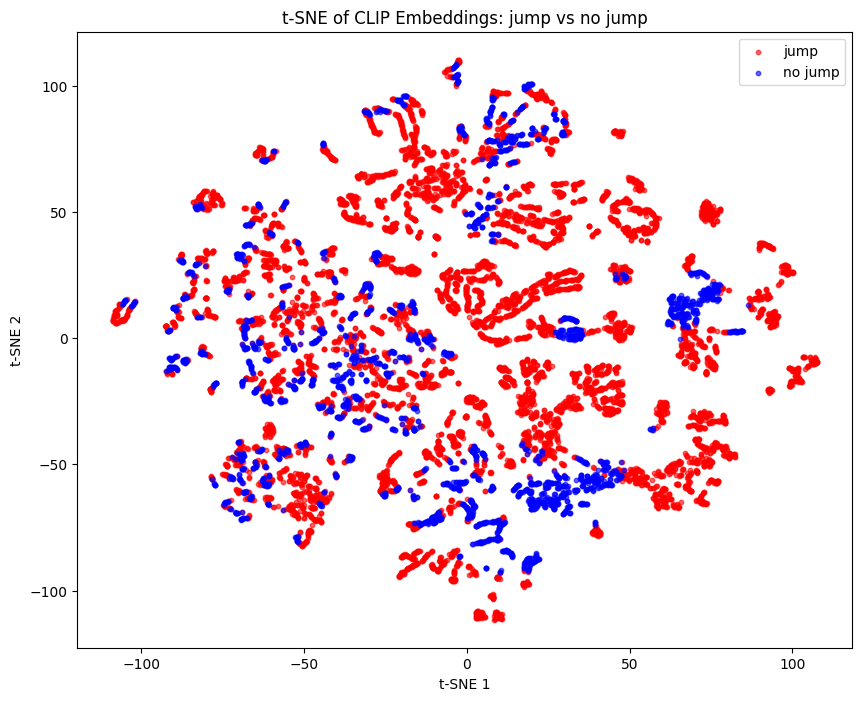

In [67]:
embeddings = []
labels = []
label_names = []

with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        image_name = row['image_label']  # column name as in your CSV
        label = int(row['label'])
        embedding_file = os.path.splitext(image_name)[0] + '.npy'
        embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
        if os.path.exists(embedding_path):
            emb = np.load(embedding_path)
            embeddings.append(emb)
            labels.append(label)
            label_names.append(image_name)
        else:
            print(f"Missing embedding for {embedding_path}")

embeddings = np.array(embeddings)
labels = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']
for label_value, color, label_str in zip([0, 1], colors, LABELS):
    idx = labels == label_value
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=label_str, alpha=0.6, s=10)

plt.legend()
plt.title('t-SNE of CLIP Embeddings: jump vs no jump')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

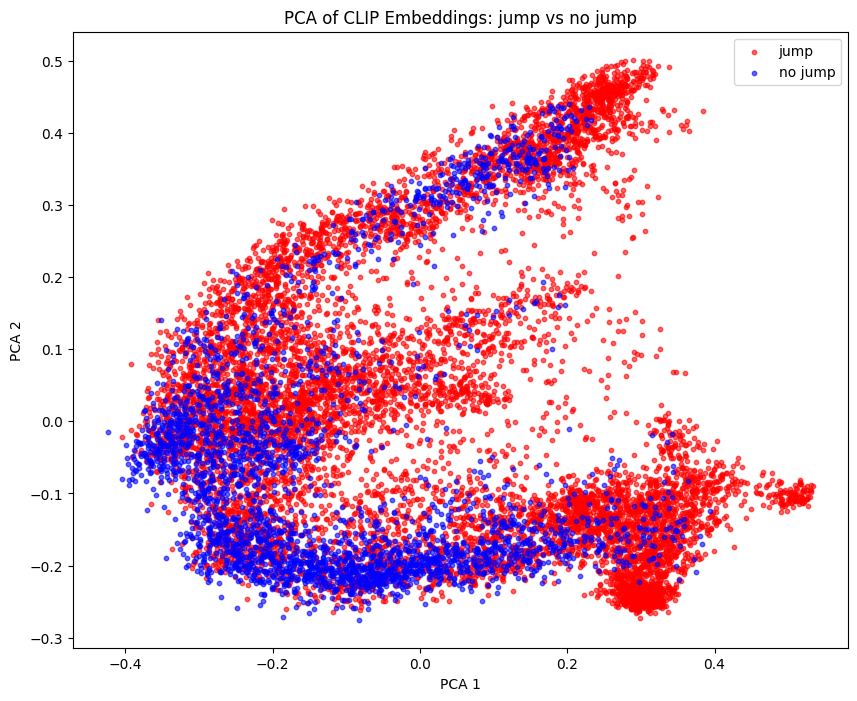

In [68]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot (reuse existing code)
plt.figure(figsize=(10, 8))
for label_value, color, label_str in zip([0, 1], colors, LABELS):
    idx = labels == label_value
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=label_str, alpha=0.6, s=10)

plt.legend()
plt.title('PCA of CLIP Embeddings: jump vs no jump')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



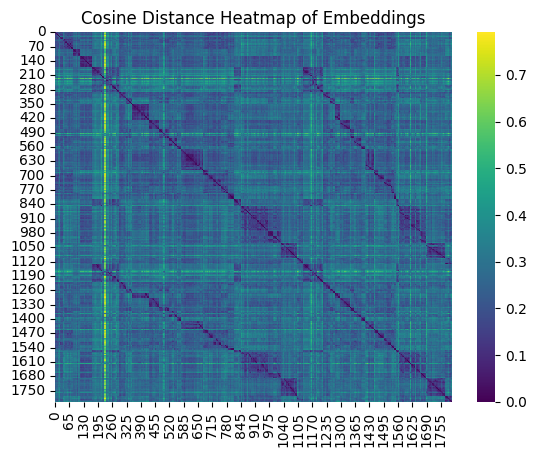

In [62]:
dist_matrix = cosine_distances(embeddings)
sns.heatmap(dist_matrix, cmap='viridis')
plt.title('Cosine Distance Heatmap of Embeddings')
plt.show()

In [20]:
# 1. Read CSV and group by video
video_to_rows = {}
with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        video = row['video']
        if video not in video_to_rows:
            video_to_rows[video] = []
        video_to_rows[video].append(row)

In [21]:
# 2. Split videos into train/val
videos = list(video_to_rows.keys())
train_videos, val_videos = train_test_split(videos, test_size=0.1, random_state=37)
print(f"Train videos: {len(train_videos)}")
print(f"Validation videos: {len(val_videos)}")

Train videos: 182
Validation videos: 21


In [22]:
def load_data(video_list):
    X, y = [], []
    for video in video_list:
        for row in video_to_rows[video]:
            image_name = row['image_label']
            label = int(row['label'])
            embedding_file = os.path.splitext(image_name)[0] + '.npy'
            embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
            if os.path.exists(embedding_path):
                emb = np.load(embedding_path)
                X.append(emb)
                y.append(label)
    return np.array(X), np.array(y)

In [23]:
# 3. Load embeddings and labels
X_train, y_train = load_data(train_videos)
X_val, y_val = load_data(val_videos)

print(f"Train samples: {len(y_train)}, Val samples: {len(y_val)}")

Train samples: 10934, Val samples: 1131



Training Logistic Regression...
Validation Accuracy: 0.9027
              precision    recall  f1-score   support

     no jump       0.89      1.00      0.94       858
        jump       0.98      0.61      0.75       273

    accuracy                           0.90      1131
   macro avg       0.94      0.80      0.85      1131
weighted avg       0.91      0.90      0.89      1131



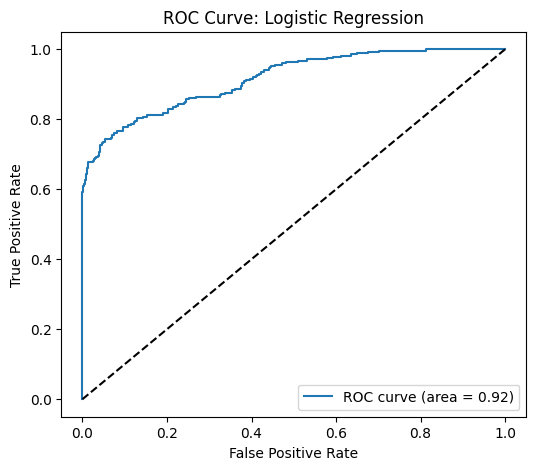

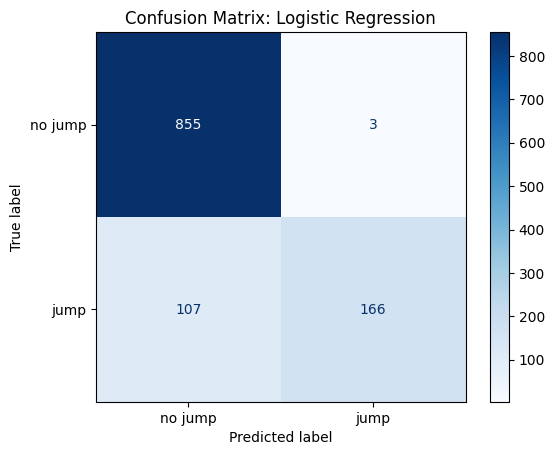


Training Linear SVM...
Validation Accuracy: 0.9204
              precision    recall  f1-score   support

     no jump       0.91      0.99      0.95       858
        jump       0.97      0.69      0.81       273

    accuracy                           0.92      1131
   macro avg       0.94      0.84      0.88      1131
weighted avg       0.92      0.92      0.92      1131



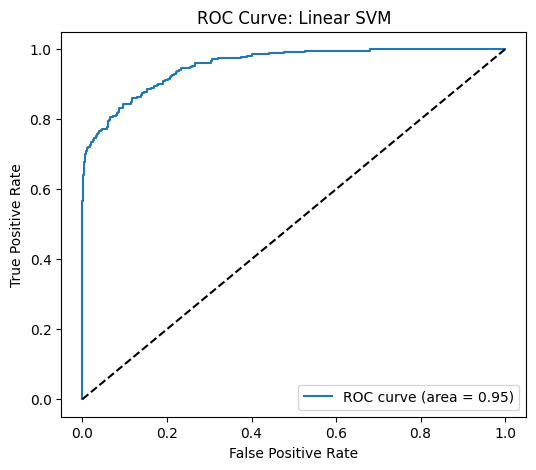

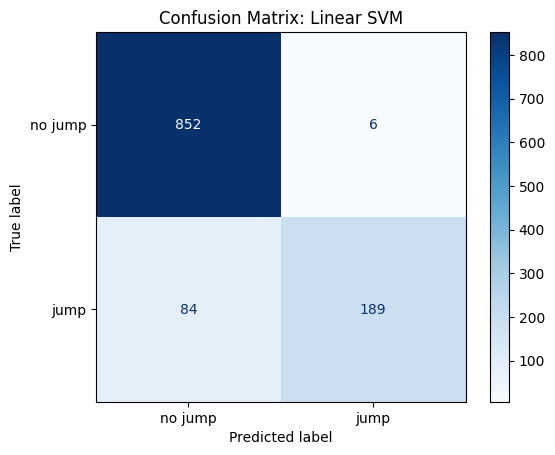


Training Kernel SVM (RBF)...
Validation Accuracy: 0.9248
              precision    recall  f1-score   support

     no jump       0.91      1.00      0.95       858
        jump       0.98      0.70      0.82       273

    accuracy                           0.92      1131
   macro avg       0.95      0.85      0.89      1131
weighted avg       0.93      0.92      0.92      1131



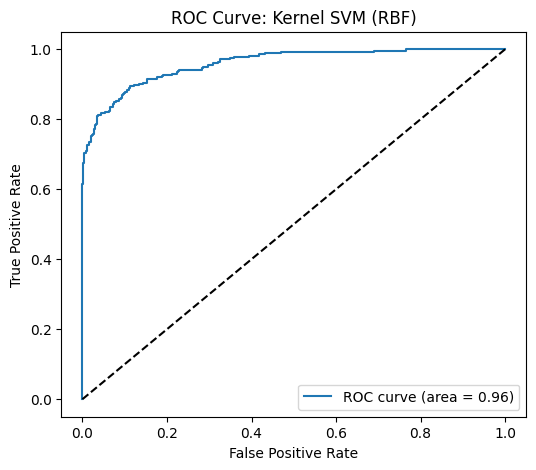

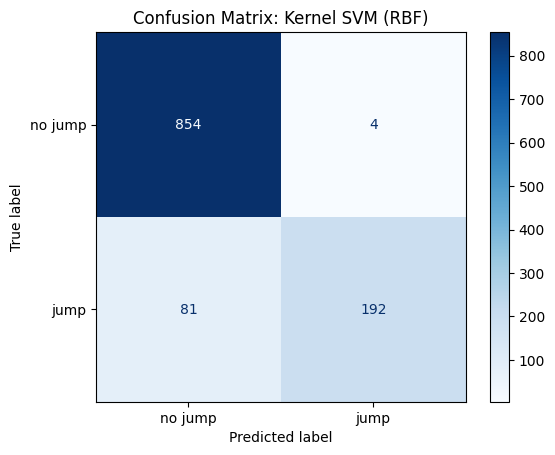


Training Polynomial SVM (degree 3)...
Validation Accuracy: 0.9257
              precision    recall  f1-score   support

     no jump       0.92      0.99      0.95       858
        jump       0.96      0.72      0.82       273

    accuracy                           0.93      1131
   macro avg       0.94      0.86      0.89      1131
weighted avg       0.93      0.93      0.92      1131



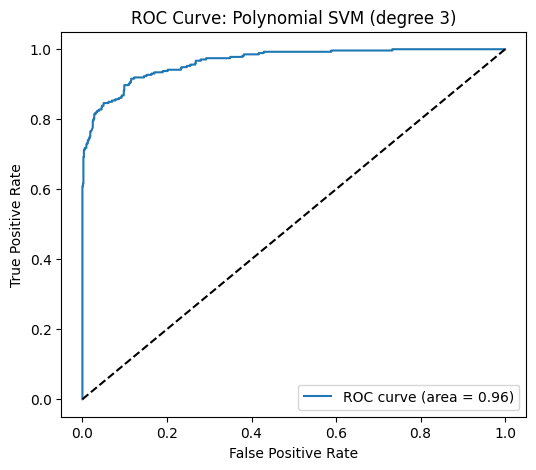

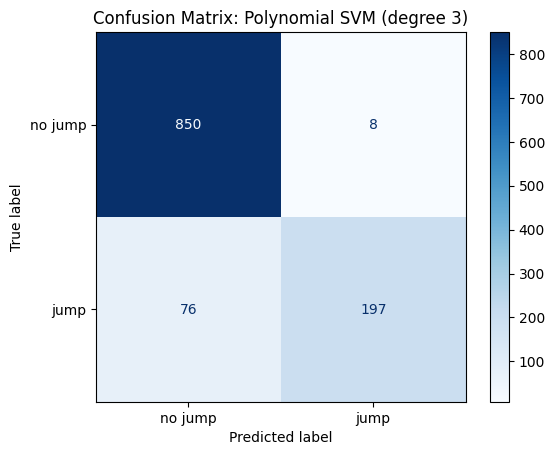


Training Sigmoid SVM...
Validation Accuracy: 0.8904
              precision    recall  f1-score   support

     no jump       0.89      0.98      0.93       858
        jump       0.91      0.61      0.73       273

    accuracy                           0.89      1131
   macro avg       0.90      0.79      0.83      1131
weighted avg       0.89      0.89      0.88      1131



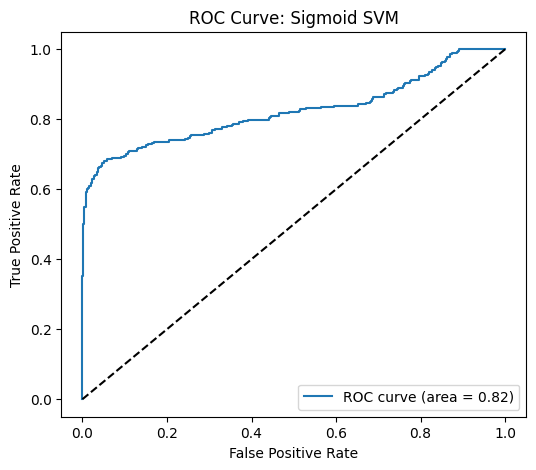

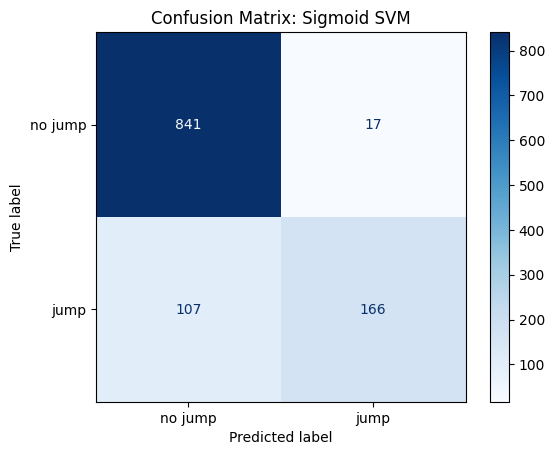


Training Random Forest...
Validation Accuracy: 0.8983
              precision    recall  f1-score   support

     no jump       0.88      1.00      0.94       858
        jump       0.99      0.58      0.73       273

    accuracy                           0.90      1131
   macro avg       0.94      0.79      0.84      1131
weighted avg       0.91      0.90      0.89      1131



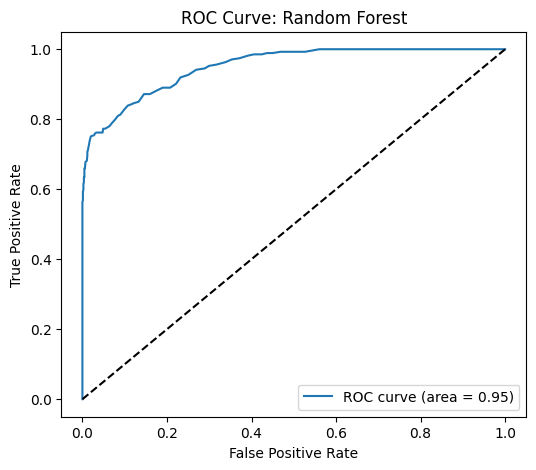

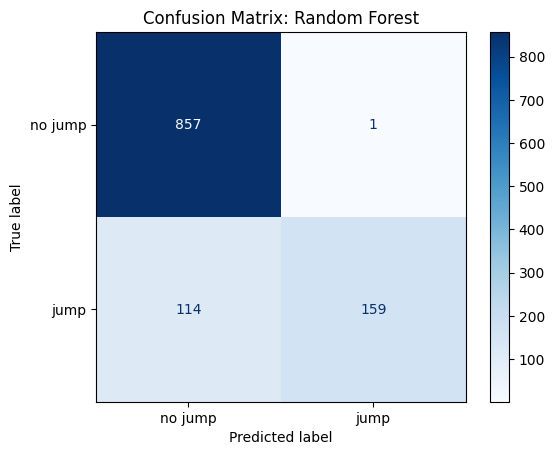


Training K-Nearest Neighbors...
Validation Accuracy: 0.9080
              precision    recall  f1-score   support

     no jump       0.94      0.94      0.94       858
        jump       0.81      0.81      0.81       273

    accuracy                           0.91      1131
   macro avg       0.87      0.88      0.87      1131
weighted avg       0.91      0.91      0.91      1131



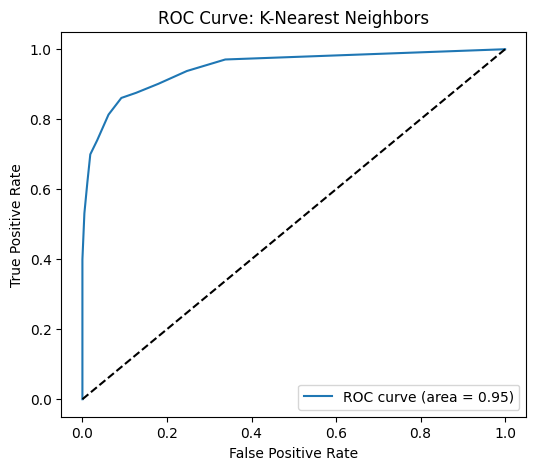

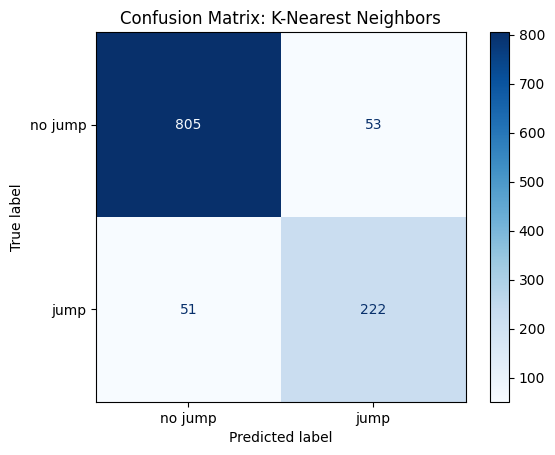


Summary of Validation Accuracies:
Logistic Regression: 0.9027
Linear SVM: 0.9204
Kernel SVM (RBF): 0.9248
Polynomial SVM (degree 3): 0.9257
Sigmoid SVM: 0.8904
Random Forest: 0.8983
K-Nearest Neighbors: 0.9080


In [80]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Kernel SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Polynomial SVM (degree 3)": SVC(kernel='poly', degree=3, probability=True),
    "Sigmoid SVM": SVC(kernel='sigmoid', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=11)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, target_names=['no jump', 'jump']))
    results[name] = acc

    # ROC Curve
    plt.figure(figsize=(6, 5))
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val)[:, 1]
    else:
        # For LinearSVC, use decision_function
        y_score = clf.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no jump', 'jump'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


# Print summary
print("\nSummary of Validation Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

In [24]:
clf = SVC(kernel='poly', degree=3, probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=['no jump', 'jump']))

Validation Accuracy: 0.9257
              precision    recall  f1-score   support

     no jump       0.92      0.99      0.95       858
        jump       0.96      0.72      0.82       273

    accuracy                           0.93      1131
   macro avg       0.94      0.86      0.89      1131
weighted avg       0.93      0.93      0.92      1131



In [27]:
# Video input/output paths
video_path = r"C:\Users\littl\Downloads\test_jump_videos\WhatsApp Video 2025-07-28 at 19.45.43_d78cfb05.mp4"
video_name = os.path.basename(video_path)
output_video_path = f"jumps/{video_name}"

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Writer to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_count = 0
time_taken_by_clip = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Convert frame to RGB and PIL
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    start = time.time()
    img_tensor = preprocess(pil_image).unsqueeze(0).to(device)

    # Get CLIP embedding
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    
    end = time.time()
    
    time_taken_by_clip += (end - start)

    # Predict using SVM
    embedding_np = img_feat.squeeze(0).cpu().numpy().reshape(1, -1)
    pred = clf.predict(embedding_np)[0]
    prob = clf.predict_proba(embedding_np)[0].max()

    # Overlay prediction on frame
    label_text = f"{'jump' if pred == 1 else 'no jump'} ({prob:.2f})"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0) if pred == 1 else (0, 0, 255), 2)

    # Write frame to output video
    out.write(frame)

    # (Optional) Show live preview
    # cv2.imshow('Prediction', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
out.release()
cv2.destroyAllWindows()
print("Done! Saved to:", output_video_path)
print(f"Time taken by CLIP: {time_taken_by_clip:.2f} seconds")

Done! Saved to: jumps/WhatsApp Video 2025-07-28 at 19.45.43_d78cfb05.mp4
Time taken by CLIP: 10.58 seconds
